In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import torchvision.transforms as transforms
import glob
import torchvision
import time
import random
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [ ]:
!nvidia-smi

Fri Sep 22 03:44:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:
torch.cuda.is_available()

True

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import RandomChoice

ROOT_DIR_TRAIN = "/content/drive/MyDrive/PlantDoc-Dataset/train"
ROOT_DIR_TEST = "/content/drive/MyDrive/PlantDoc-Dataset/test"

# Transforms for training with Random Erase
train_transform =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

# Transforms for validation/testing
test_valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Prepare the Dataset
dataset_train = datasets.ImageFolder(root=ROOT_DIR_TRAIN, transform=train_transform)
dataset_valid = datasets.ImageFolder(root=ROOT_DIR_TRAIN, transform=test_valid_transform)
test_dataset = datasets.ImageFolder(root=ROOT_DIR_TEST, transform=test_valid_transform)

train_size = int(0.80 * len(dataset_train))
valid_size = len(dataset_train) - train_size

# Radomize the data indices.
indices = torch.randperm(len(dataset_train)).tolist()
# Training and validation sets.
train_dataset = Subset(dataset_train, indices[:-valid_size])
valid_dataset = Subset(dataset_valid, indices[-valid_size:])

# Prepare the Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
num_images = len(dataset_train)
num_classes = len(dataset_train.classes)
print(f"Number of Images: {num_images}")
print(f"Number of Classes: {num_classes}")

Number of Images: 2316
Number of Classes: 27


In [ ]:
num_images = len(test_dataset)
num_classes = len(test_dataset.classes)
print(f"Number of Images: {num_images}")
print(f"Number of Classes: {num_classes}")

Number of Images: 236
Number of Classes: 27


In [ ]:
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(valid_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Number of training images: 1852
Number of validation images: 464
Number of test images: 236


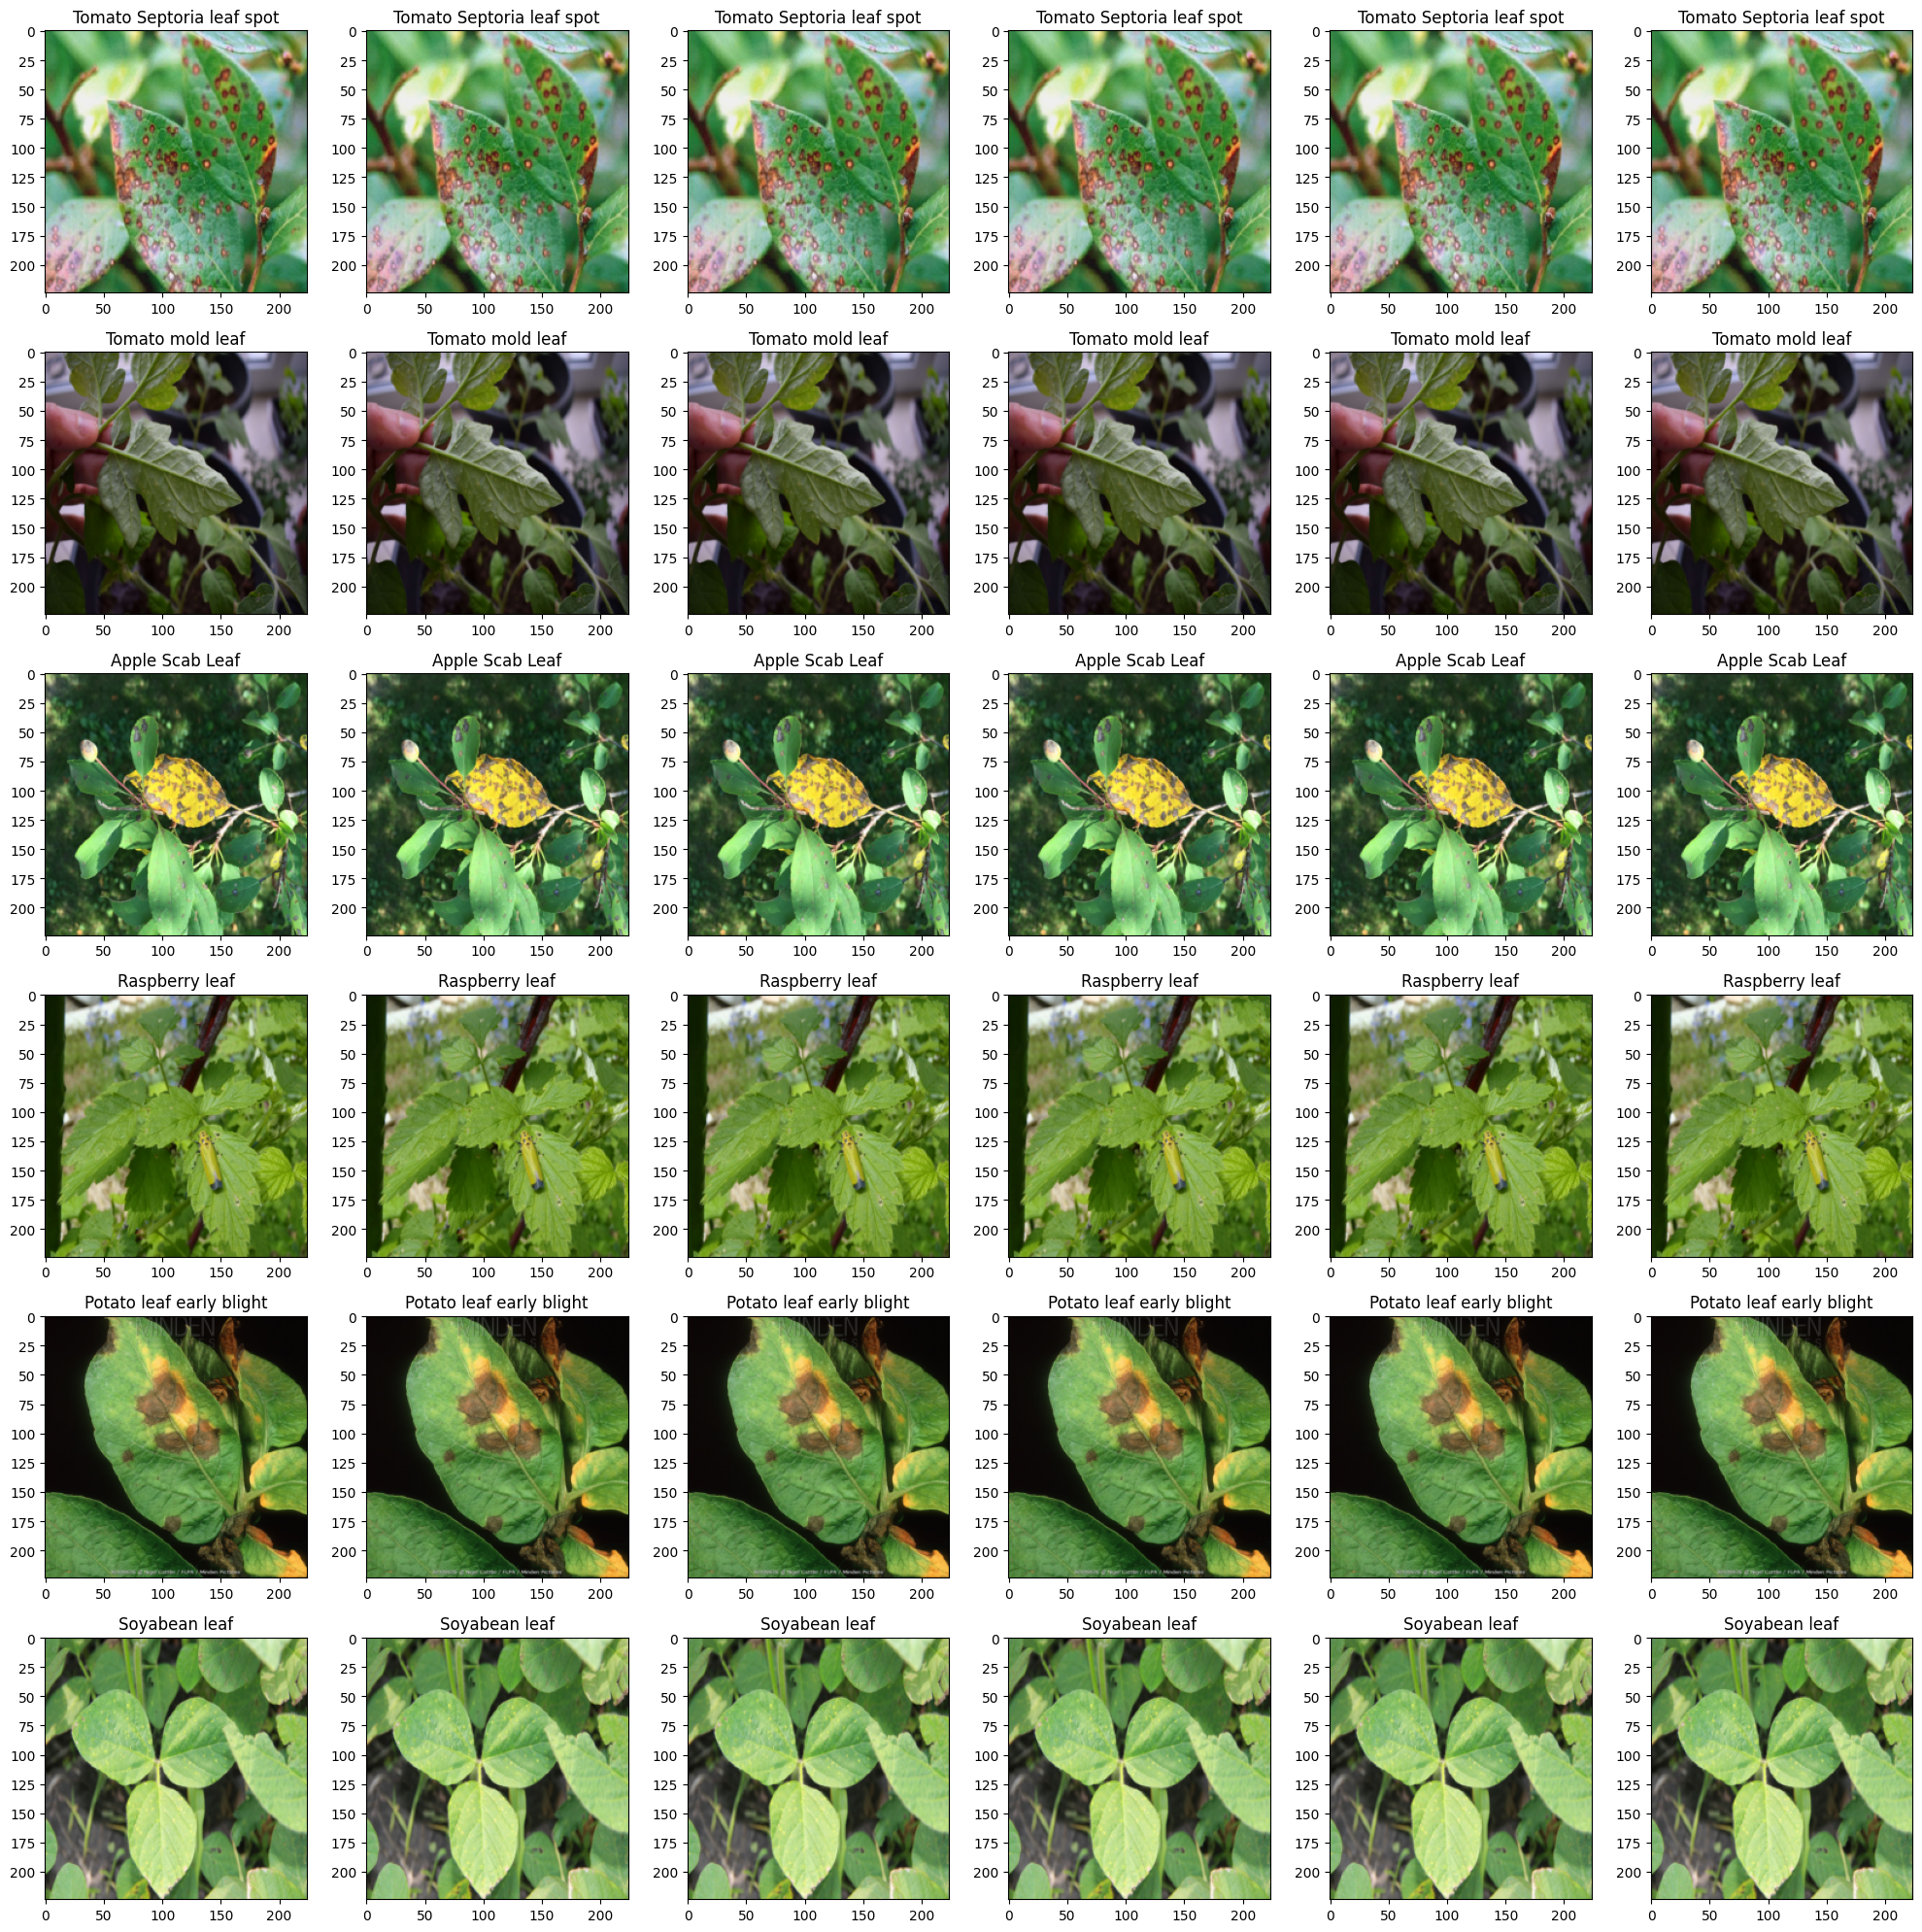

In [ ]:
def show_dataset(dataset_train, n=6):
    fig, axs = plt.subplots(n, n, figsize=(20, 20))

    for row in range(n):
        idx = np.random.randint(len(dataset_train))  # select the same index for each row
        for col in range(n):
            images, labels = dataset_train[idx]
            images = images.permute(1, 2, 0)  # CxHxW -> HxWxC
            images = images * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])  # denormalize
            images = (images * 255).byte().numpy()  # convert to uint8 numpy array
            axs[row, col].imshow(images)
            axs[row, col].set_title(dataset_train.classes[labels])
            axs[row, col].axis()

    plt.tight_layout()
    plt.show()

# Show Dataset
show_dataset(dataset_train)

In [ ]:
from torchvision import models
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [ ]:
!pip install torchinfo

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.5 MB/s eta 0:00:00


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchinfo import summary
import timm

class ResNetViT(nn.Module):
    def __init__(self, num_classes=27):
        super(ResNetViT, self).__init__()

        self.num_classes = num_classes

        # ResNet-50 for feature maps
        resnet50 = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet50.children())[:-2])  # Remove avgpool and fc layer

        # Projection layer for ViT
        self.proj_layer = nn.Conv2d(2048, 3, kernel_size=1, stride=1, padding=0)

        # Load pretrained ViT model
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()

        # Custom head for mask generation
        self.custom_head = nn.Linear(self.vit.embed_dim, 2048*7*7)
        #self.custom_head = nn.Linear(self.vit.embed_dim, 49*num_classes)

        # Final classifier
        self.fc = nn.Linear(2048*7*7, num_classes)

    def forward(self, x):
        feature_maps = self.feature_extractor(x)
        feature_maps = feature_maps.view(-1, 2048*7*7)
        #print(feature_maps.shape)

        # Resize for ViT
        #resized_feature_maps = nn.functional.interpolate(feature_maps, size=(224, 224), mode='bilinear')
        #resized_feature_maps = self.proj_layer(resized_feature_maps)  # Project to 3 channels

        # ViT for masks
        #masks = self.vit(resized_feature_maps)
        masks = self.vit(x)
        masks = self.custom_head(masks)
        #print(masks.shape)
        #masks = masks.view(-1, self.num_classes, 7, 7)
        #masks = torch.softmax(masks, dim=1)  # Consider replacing with softmax if masks are independent

        # Apply masks to feature maps
        mean_mask = torch.mean(masks, dim=1, keepdim=True)
        masked_feature_maps = feature_maps * mean_mask

        # Flatten and classify
        flattened = masked_feature_maps.view(masked_feature_maps.size(0), -1)
        out = self.fc(flattened)

        return out

# Instantiate and summarize the model
model = ResNetViT().to(device)
summary(model, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
ResNetViT                                     [1, 27]                   6,147
├─Sequential: 1-1                             [1, 2048, 7, 7]           --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          70,400
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]          379,

In [ ]:
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset
import numpy as np

def train_model(model, criterion, optimizer, dataloader, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

def validate_model(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
def test_model(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects.double() / len(test_loader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
# Set the number of folds
num_folds = 5

# Prepare the data
X = np.arange(len(dataset_train))
y = np.array([label for _, label in dataset_valid.imgs])

# Set up the StratifiedKFold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize lists to store fold results
fold_train_losses = []
fold_valid_losses = []
fold_test_losses = []
fold_train_accs = []
fold_valid_accs = []
fold_test_accs = []

# เชื่อมต่อ Google Drive
checkpoint_path = '/content/drive/MyDrive/PlantDoc-Dataset/fold_checkpoint.txt'

if os.path.exists(checkpoint_path):
    with open(checkpoint_path, "r") as f:
        start_fold = int(f.read().strip())
else:
    start_fold = 0

for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    if fold < start_fold:
        continue

    print(f"Fold {fold + 1}/{num_folds}")

    # Create data loaders for the current fold
    train_data = Subset(dataset_train, train_index)
    valid_data = Subset(dataset_valid, valid_index)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Load and prepare the model
    model = ResNetViT().to(device)

    # Set the criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Train and validate the model
    num_epochs = 50
    epoch_train_losses = []
    epoch_valid_losses = []
    epoch_test_losses = []
    epoch_train_accs = []
    epoch_valid_accs = []
    epoch_test_accs = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, criterion, optimizer, train_loader, device)
        valid_loss, valid_acc = validate_model(model, criterion, valid_loader, device)
        test_loss, test_acc = test_model(model, criterion, test_loader, device)

        epoch_train_losses.append(train_loss)
        epoch_valid_losses.append(valid_loss)
        epoch_test_losses.append(test_loss)
        epoch_train_accs.append(train_acc)
        epoch_valid_accs.append(valid_acc)
        epoch_test_accs.append(test_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f} Train Accuracy: {train_acc * 100:.4f} "
              f"Valid Loss: {valid_loss:.4f} Valid Accuracy: {valid_acc * 100:.4f} "
              f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc * 100:.4f}")

    fold_train_losses.append(epoch_train_losses)
    fold_valid_losses.append(epoch_valid_losses)
    fold_test_losses.append(epoch_test_losses)
    fold_train_accs.append(epoch_train_accs)
    fold_valid_accs.append(epoch_valid_accs)
    fold_test_accs.append(epoch_test_accs)

    print("Finished Fold")
    print("=" * 50)

    # เมื่อเสร็จ fold นั้น บันทึกสถานะ
    with open(checkpoint_path, "w") as f:
      f.write(str(fold + 1))

Fold 1/5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50: Train Loss: 3.2947 Train Accuracy: 6.3715 Valid Loss: 3.2925 Valid Accuracy: 7.9741 Test Loss: 3.2937 Test Accuracy: 7.2034
Epoch 2/50: Train Loss: 3.2884 Train Accuracy: 10.4752 Valid Loss: 3.2812 Valid Accuracy: 10.7759 Test Loss: 3.2802 Test Accuracy: 9.3220
Epoch 3/50: Train Loss: 3.2355 Train Accuracy: 14.6328 Valid Loss: 3.1279 Valid Accuracy: 14.8707 Test Loss: 3.1031 Test Accuracy: 13.1356
Epoch 4/50: Train Loss: 2.8118 Train Accuracy: 19.1145 Valid Loss: 2.5934 Valid Accuracy: 24.7845 Test Loss: 2.6442 Test Accuracy: 19.9153
Epoch 5/50: Train Loss: 2.2202 Train Accuracy: 37.6350 Valid Loss: 2.2448 Valid Accuracy: 38.1466 Test Loss: 2.2450 Test Accuracy: 35.1695
Epoch 6/50: Train Loss: 1.5514 Train Accuracy: 60.8531 Valid Loss: 2.0881 Valid Accuracy: 45.2586 Test Loss: 2.0455 Test Accuracy: 41.5254
Epoch 7/50: Train Loss: 1.1518 Train Accuracy: 75.8639 Valid Loss: 1.5419 Valid Accuracy: 53.8793 Test Loss: 1.7010 Test Accuracy: 49.1525
Epoch 8/50: Train Loss: 0.6160 

In [ ]:
# Evaluate the trained model on the training and validation sets for each fold.
avg_train_acc_k_folds = []
avg_val_acc_k_folds = []

def evaluate_accuracy(history, index):
    history_cpu = [item.cpu() for item in history]
    return sum(history_cpu) / len(history_cpu)

for i in range(num_folds):
    train_accuracy = evaluate_accuracy(fold_train_accs[i], 2)
    valid_accuracy = evaluate_accuracy(fold_valid_accs[i], 3)
    print(f'Fold {i + 1}/{num_folds}:')
    print(f'\tTraining Accuracy: {train_accuracy * 100:.2f}%')
    print(f'\tValidation Accuracy: {valid_accuracy * 100:.2f}%')
    avg_train_acc_k_folds.append(train_accuracy)
    avg_val_acc_k_folds.append(valid_accuracy)

# Compute the average training and validation accuracy over all folds.
overall_train_acc = sum(avg_train_acc_k_folds) / len(avg_train_acc_k_folds)
overall_val_acc = sum(avg_val_acc_k_folds) / len(avg_val_acc_k_folds)

# Calculate the average and standard deviation of the training and validation accuracy over all folds.
avg_train_acc = np.mean(avg_train_acc_k_folds)
std_train_acc = np.std(avg_train_acc_k_folds)
avg_val_acc = np.mean(avg_val_acc_k_folds)
std_val_acc = np.std(avg_val_acc_k_folds)

# Print the average and standard deviation of the training and validation accuracy over all folds.
print(f'\nAverage Training Accuracy over {num_folds}-fold Cross Validation: {avg_train_acc * 100:.2f}% +/- {std_train_acc * 100:.2f}%')
print(f'Average Validation Accuracy over {num_folds}-fold Cross Validation: {avg_val_acc * 100:.2f}% +/- {std_val_acc * 100:.2f}%')

Fold 1/5:
	Training Accuracy: 88.74%
	Validation Accuracy: 53.60%
Fold 2/5:
	Training Accuracy: 89.93%
	Validation Accuracy: 54.22%
Fold 3/5:
	Training Accuracy: 87.60%
	Validation Accuracy: 52.99%
Fold 4/5:
	Training Accuracy: 92.72%
	Validation Accuracy: 57.56%
Fold 5/5:
	Training Accuracy: 89.41%
	Validation Accuracy: 55.44%

Average Training Accuracy over 5-fold Cross Validation: 89.68% +/- 1.71%
Average Validation Accuracy over 5-fold Cross Validation: 54.76% +/- 1.62%


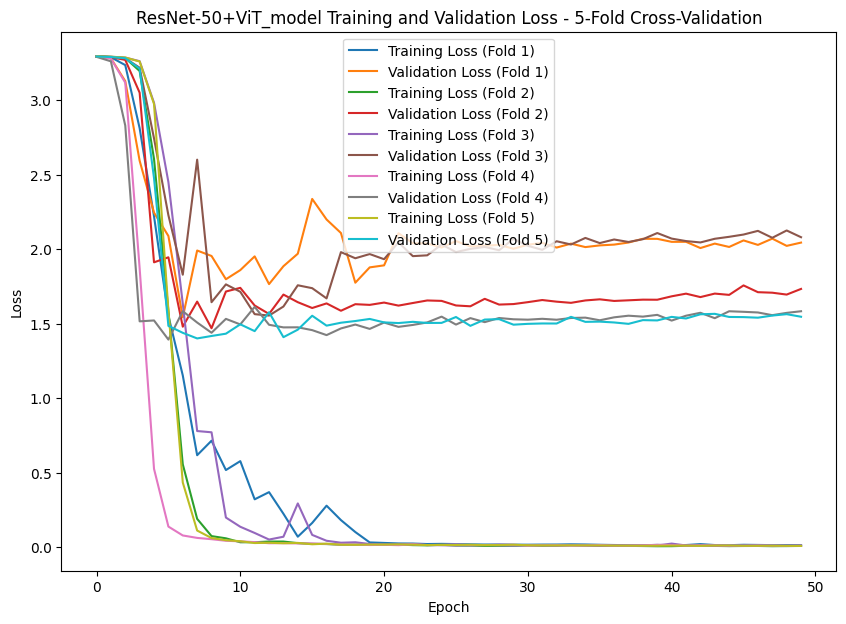

In [ ]:
# Plot the training and validation loss for each epoch
model_name = "ResNet-50+ViT_model"
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(fold_train_losses[fold], label=f'Training Loss (Fold {fold+1})')
    plt.plot(fold_valid_losses[fold], label=f'Validation Loss (Fold {fold+1})')

plt.title(f'{model_name} Training and Validation Loss - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

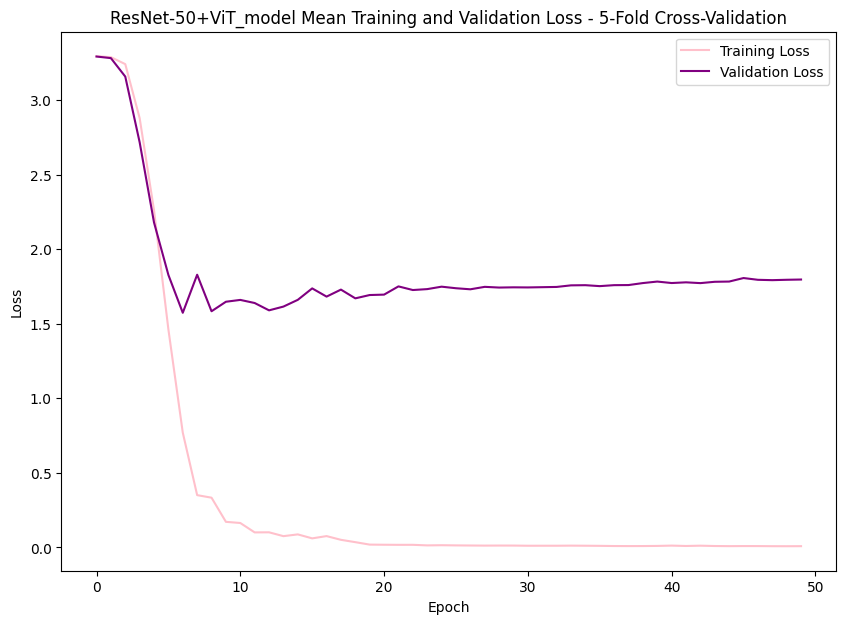

In [ ]:
# Compute mean loss across all folds at each epoch
train_loss_mean = np.mean([np.array(fold_train_losses[i]) for i in range(num_folds)], axis=0)
valid_loss_mean = np.mean([np.array(fold_valid_losses[i]) for i in range(num_folds)], axis=0)

# Plot mean loss history
plt.figure(figsize=(10, 7))
plt.plot(train_loss_mean, label='Training Loss', color='pink')
plt.plot(valid_loss_mean, label='Validation Loss', color='purple')
plt.title(f'{model_name} Mean Training and Validation Loss - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

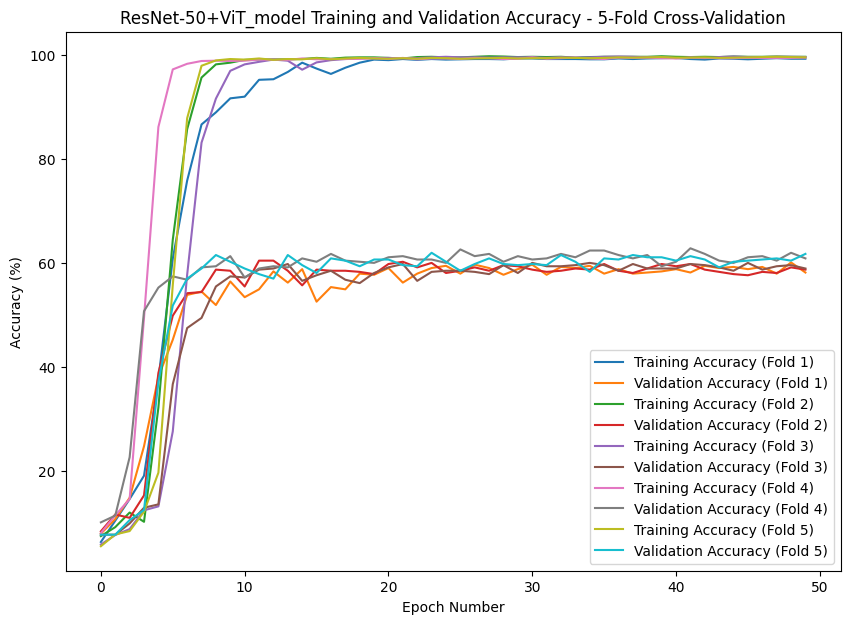

In [ ]:
# Plot the training and validation accuracy for each epoch
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(np.array([acc.cpu() for acc in fold_train_accs[fold]]) * 100, label=f'Training Accuracy (Fold {fold+1})')
    plt.plot(np.array([acc.cpu() for acc in fold_valid_accs[fold]]) * 100, label=f'Validation Accuracy (Fold {fold+1})')

plt.title(f'{model_name} Training and Validation Accuracy - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

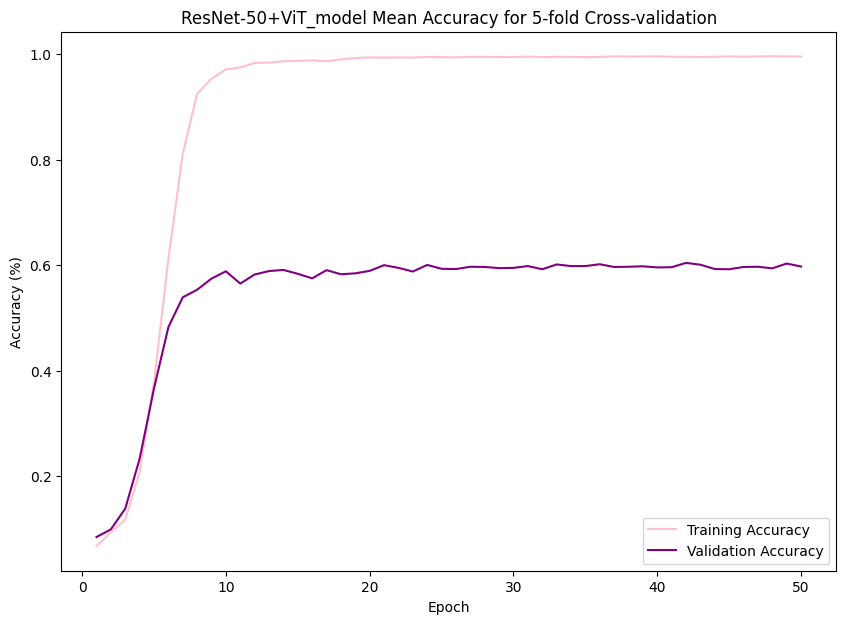

In [ ]:
# Compute mean accuracy across all folds at each epoch
train_acc_mean = np.mean([np.array([acc.cpu() for acc in fold_train_accs[i]]) for i in range(num_folds)], axis=0)
valid_acc_mean = np.mean([np.array([acc.cpu() for acc in fold_valid_accs[i]]) for i in range(num_folds)], axis=0)

# Plot mean accuracy history
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, num_epochs + 1), train_acc_mean, label='Training Accuracy', color='pink')
plt.plot(np.arange(1, num_epochs + 1), valid_acc_mean, label='Validation Accuracy', color='purple')
plt.title(f'{model_name} Mean Accuracy for {num_folds}-fold Cross-validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
# Evaluate the trained model on the test sets for each fold.
avg_test_acc_k_folds = []

def evaluate_accuracy(history, index):
    history_cpu = [item.cpu() for item in history]
    return sum(history_cpu) / len(history_cpu)

for i in range(num_folds):
    test_accuracy = evaluate_accuracy(fold_test_accs[i], 2)
    print(f'Fold {i + 1}/{num_folds}:')
    print(f'\tTest Accuracy: {test_accuracy * 100:.2f}%')
    avg_test_acc_k_folds.append(test_accuracy)

# Compute the average test accuracy over all folds.
overall_test_acc = sum(avg_test_acc_k_folds) / len(avg_test_acc_k_folds)

# Calculate the average and standard deviation of the test accuracy over all folds.
avg_test_acc = np.mean(avg_test_acc_k_folds)
std_test_acc = np.std(avg_test_acc_k_folds)

# Print the average and standard deviation of the test accuracy over all folds.
print(f'\nAverage Test Accuracy over {num_folds}-fold Cross Validation: {avg_test_acc * 100:.2f}% +/- {std_test_acc * 100:.2f}%')

Fold 1/5:
	Test Accuracy: 50.62%
Fold 2/5:
	Test Accuracy: 51.77%
Fold 3/5:
	Test Accuracy: 52.34%
Fold 4/5:
	Test Accuracy: 52.99%
Fold 5/5:
	Test Accuracy: 51.13%

Average Test Accuracy over 5-fold Cross Validation: 51.77% +/- 0.84%


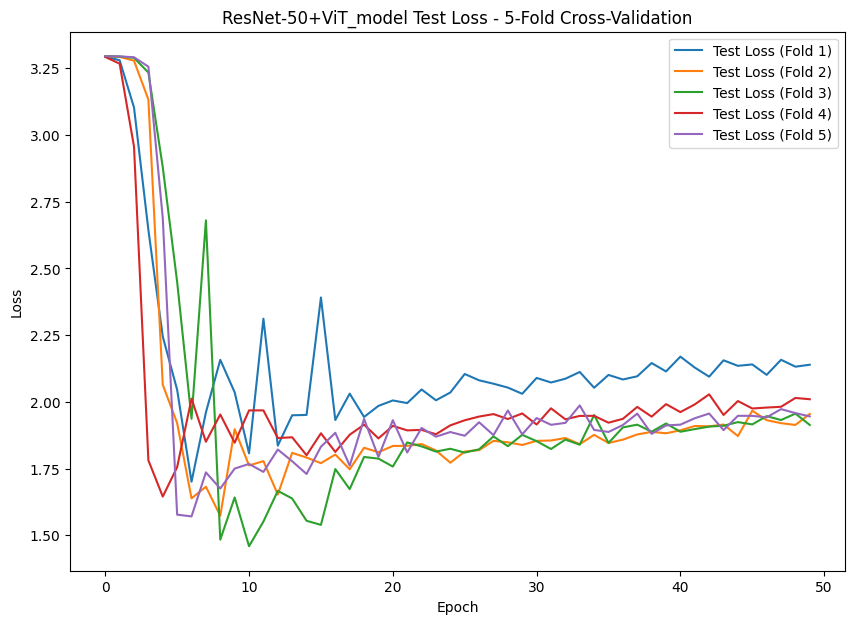

In [ ]:
# Plot the test loss for each epoch
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(fold_test_losses[fold], label=f'Test Loss (Fold {fold+1})')

plt.title(f'{model_name} Test Loss - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

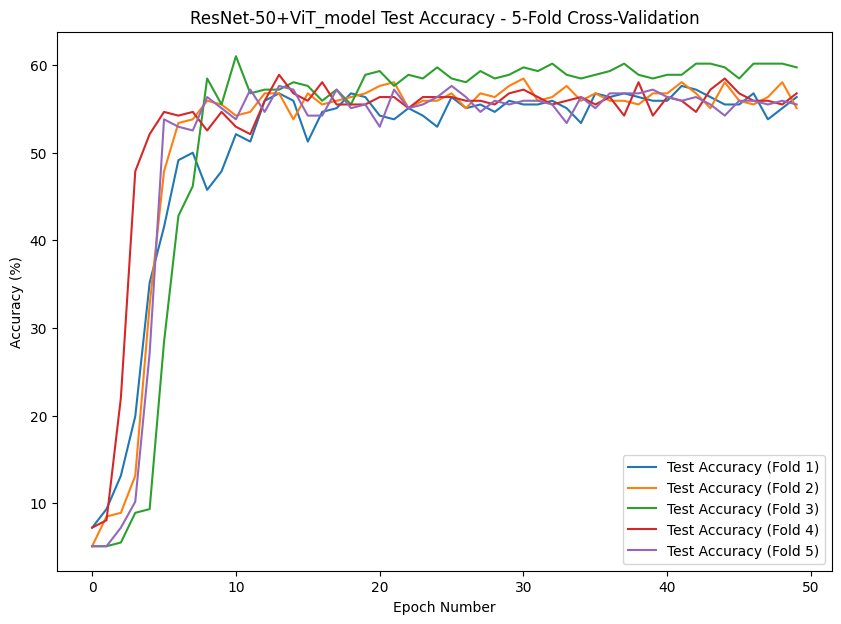

In [ ]:
# Plot the test accuracy for each epoch
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(np.array([acc.cpu() for acc in fold_test_accs[fold]]) * 100, label=f'Test Accuracy (Fold {fold+1})')

plt.title(f'{model_name} Test Accuracy - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
print("Classes: ")
class_names = test_dataset.classes
print(test_dataset.classes)

Classes: 
['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# สมมุติว่า `model` คือโมเดลที่คุณได้ทำการฝึกฝนเสร็จสิ้นแล้ว
# และ `test_loader` คือ DataLoader สำหรับข้อมูลทดสอบ

all_labels, all_preds = [], []
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    all_labels.extend(labels.tolist())
    all_preds.extend(preds.tolist())

# พิมพ์ confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 9  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 2  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0]
 [ 1  1  6  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  2  0  2  2  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
   1  0  0]
 [ 1  1  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  1  0  0  0
   0  0  0]
 [ 1  3  0  0  0  4  0  0  0  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  4  0  0  0  1  4  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  7  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  1  1  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  2  0  0  0  0  2  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  1  1  0  0  0  0  0  0  0  0 

In [ ]:
# พิมพ์ classification report ซึ่งจะบอก precision, recall และ F1-score
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
                             precision    recall  f1-score   support

           Apple Scab Leaf       0.56      0.90      0.69        10
                Apple leaf       0.30      0.67      0.41         9
           Apple rust leaf       0.75      0.60      0.67        10
          Bell_pepper leaf       0.50      0.25      0.33         8
     Bell_pepper leaf spot       0.50      0.44      0.47         9
            Blueberry leaf       0.67      0.36      0.47        11
               Cherry leaf       0.57      0.40      0.47        10
       Corn Gray leaf spot       0.11      0.25      0.15         4
          Corn leaf blight       0.50      0.42      0.45        12
            Corn rust leaf       1.00      0.80      0.89        10
                Peach leaf       0.62      0.56      0.59         9
  Potato leaf early blight       0.30      0.38      0.33         8
   Potato leaf late blight       0.57      0.50      0.53         8
            Raspberry l

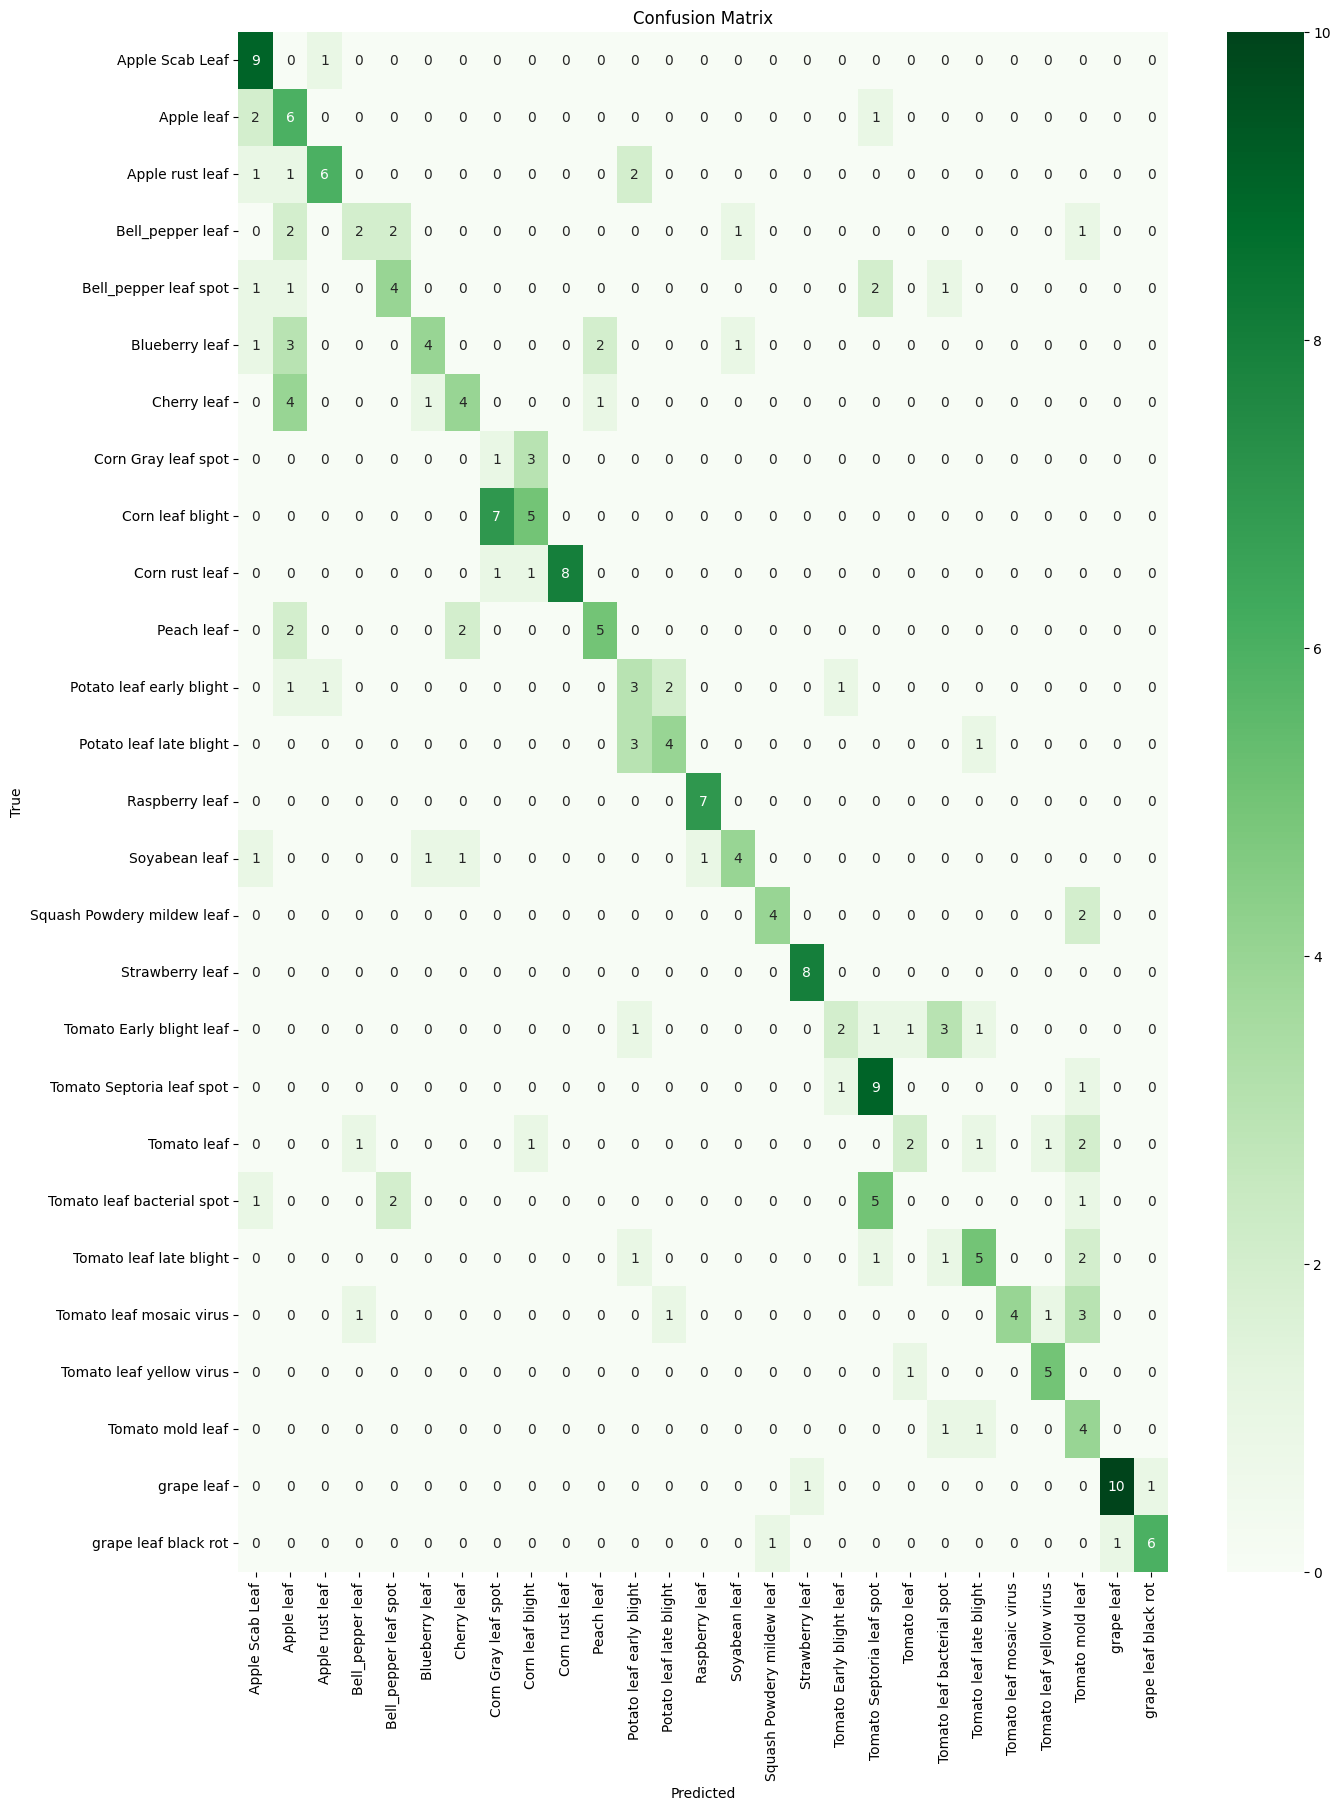

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(15, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<ipython-input-31-af32650244a3>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm_total = cm.astype(np.float).sum(axis=1)


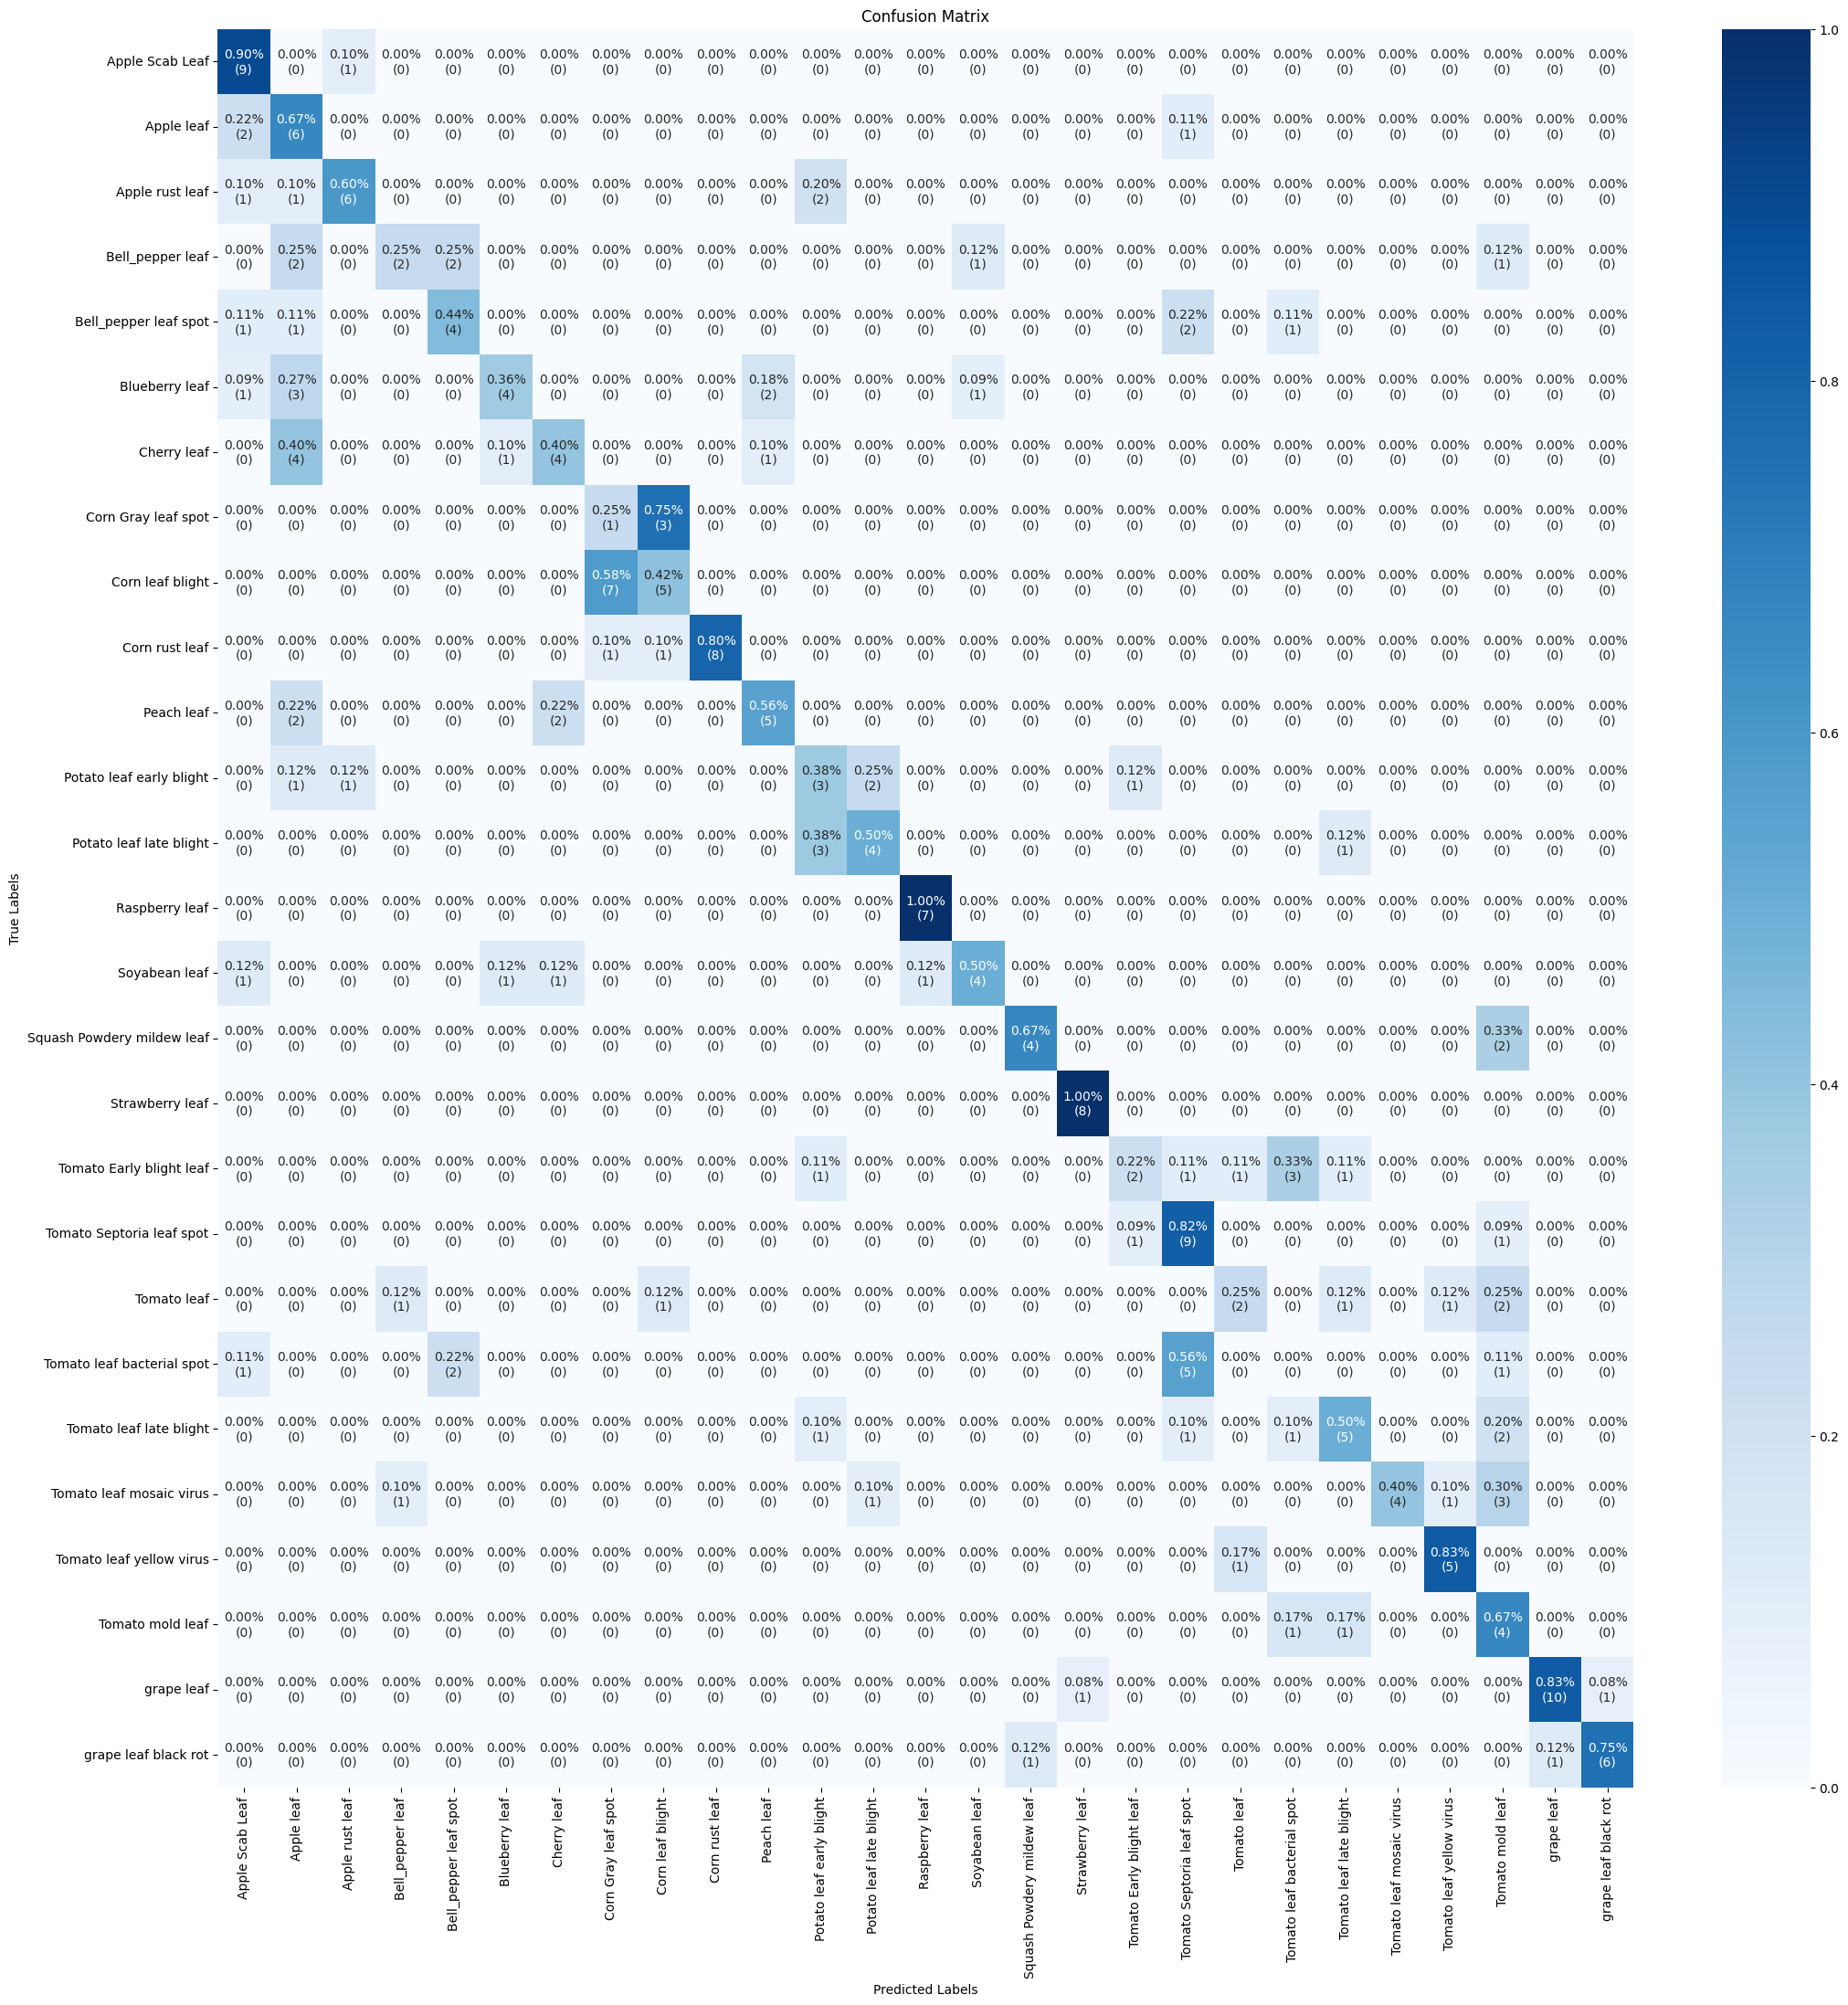

In [ ]:
def fmt(p, total):
    return '{:.2f}%\n({:.0f})'.format(p, total)

# Compute normalized confusion matrix
cm_total = cm.astype(np.float).sum(axis=1)
cm_normalized = cm.astype('float') / cm_total[:, np.newaxis]

# Compute annotations
annotations = np.vectorize(fmt)(cm_normalized, cm)

fig, ax = plt.subplots(figsize=(25, 25))
sns.heatmap(cm_normalized, annot=annotations, fmt='', cmap='Blues', ax=ax,
            xticklabels=class_names, yticklabels=class_names)
ax.set_title("Confusion Matrix")
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

plt.show()

In [ ]:
correct_samples = {class_name: [] for class_name in class_names}
incorrect_samples = {class_name: [] for class_name in class_names}

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        scores = torch.nn.functional.softmax(outputs, dim=1) * 100 # compute softmax scores

        # Iterate over the batch
        for input_image, true_label, pred_label, score in zip(inputs, labels, preds, scores):
            class_name = class_names[true_label.item()]
            if true_label == pred_label:
                # Correct prediction
                correct_samples[class_name].append((input_image.cpu(), score[pred_label.item()].item()))
            else:
                # Incorrect prediction
                incorrect_samples[class_name].append((input_image.cpu(), class_names[pred_label.item()], score[pred_label.item()].item()))

In [ ]:
def imshow(ax, inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title, fontsize=12)

# Create separate grid for each class
for i, class_name in enumerate(class_names):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for j in range(5):
        if j < len(correct_samples[class_name]):
            imshow(axes[0, j], correct_samples[class_name][j][0], title=f"Pred: {class_name}\nTrue: {class_name}\nScore: {correct_samples[class_name][j][1]:.4f}%")
        else:  # In case we don't have enough correct samples
            axes[0, j].axis('off')

        if j < len(incorrect_samples[class_name]):
            imshow(axes[1, j], incorrect_samples[class_name][j][0], title=f"Pred: {incorrect_samples[class_name][j][1]}\nTrue: {class_name}\nScore: {incorrect_samples[class_name][j][2]:.4f}%")
        else:  # In case we don't have enough incorrect samples
            axes[1, j].axis('off')

    axes[0, 0].set_ylabel("Correct samples")
    axes[1, 0].set_ylabel("Incorrect samples")

    # Add class name as a big title for each class
    fig.suptitle(class_name, fontsize=16)

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
feature_maps = {}

def hook_fn(module, input, output):
    layer_name = str(module.__class__).split('.')[-1].split("'")[0]
    if layer_name not in feature_maps:
        feature_maps[layer_name] = []
    feature_maps[layer_name].append(output)

# ลงทะเบียน hook function ให้กับทุกเลเยอร์ของ ResNet50
model = models.resnet50(pretrained=True)
for layer in model.children():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.ReLU) or isinstance(layer, nn.MaxPool2d):
        layer.register_forward_hook(hook_fn)

In [ ]:
# ตัวอย่างการใช้ DataLoader
inputs, _ = next(iter(test_loader))
outputs = model(inputs)

In [ ]:
for layer_name, maps in feature_maps.items():
    fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
    fig.suptitle(layer_name, fontsize=16)
    for i, ax in enumerate(axes.flat):
        # แสดง feature map แรกของเลเยอร์นั้น (เปลี่ยนตัวเลขเพื่อดู feature maps อื่น ๆ)
        if i < maps[0].shape[1]:
            ax.imshow(maps[0][0, i].detach().cpu().numpy(), cmap='viridis')
        ax.axis()
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from timm.models.vision_transformer import Attention

class CustomAttention(Attention):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super(CustomAttention, self).__init__(dim, num_heads, qkv_bias, qk_scale, attn_drop, proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn.detach()  # Store the attention weights
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

# Load the ViT model
model_vit = timm.create_model('vit_base_patch16_224', pretrained=True)
model_vit.eval()

# Replace the Attention modules in the pre-trained ViT with our CustomAttention
def replace_attention_modules(model):
    for block in model.blocks:
        attn_module = block.attn
        block.attn = CustomAttention(
            dim=attn_module.qkv.in_features,  # This is the way to access the 'dim' attribute
            num_heads=attn_module.num_heads,
            qkv_bias=attn_module.qkv.bias is not None,  # Check if the bias exists
            attn_drop=attn_module.attn_drop.p,  # Get dropout probability
            proj_drop=attn_module.proj_drop.p   # Get dropout probability
        )

replace_attention_modules(model_vit)

# Now, you can use the same hook function as before to capture the attention weights
attention_weights = []
def hook(module, input, output):
    if hasattr(module, 'attn_weights'):
        attention_weights.append(module.attn_weights)

# Register the hook to all attention layers
for layer in model_vit.blocks:
    layer.attn.register_forward_hook(hook)

In [ ]:
# Perform a forward pass with a sample image to get attention weights
# (You can use any image, but ensure it's processed appropriately for ViT)
# Get a sample image from the test_loader
input_image, _ = next(iter(test_loader))
# Run the model to capture the attention weights
_ = model_vit(input_image)

In [ ]:
print(len(attention_weights))

0


In [ ]:
def show_attention_maps(image, attention_weights):
    # Assuming image is of shape (3, 224, 224) and attention_weights is a list of tensors
    _, h, w = image.shape
    patch_size = 16  # For vit_base_patch16_224
    num_heads = attention_weights[0].shape[1]

    # Prepare the image for visualization
    image = image.permute(1, 2, 0)
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = (image * std + mean).clamp(0, 1)

    # Plot the original image
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Plot attention maps
    for block, block_weights in enumerate(attention_weights):
        fig, axs = plt.subplots(1, num_heads, figsize=(20, 20))
        for head, ax in enumerate(axs):
            # Take the mean over the source positions for each target position
            attn_map = block_weights[0, head].mean(dim=0)
            # Exclude the [CLS] token's attention
            attn_map = attn_map[1:]
            # Resize to visualize at image resolution
            attn_map = attn_map.reshape(int(h/patch_size), int(w/patch_size))
            attn_map = torch.nn.functional.interpolate(attn_map.unsqueeze(0).unsqueeze(0), size=(h, w), mode='nearest').squeeze().detach().numpy()
            ax.imshow(image, cmap='gray')
            ax.imshow(attn_map, cmap='viridis', alpha=0.6)
            ax.set_title(f"Block {block + 1}, Head {head + 1}")
            ax.axis('off')
        plt.tight_layout()
        plt.show()

show_attention_maps(input_image[0], attention_weights)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from torch.autograd import Variable

# เตรียมข้อมูล
inputs = Variable(torch.randn(1, 3, 224, 224))
if torch.cuda.is_available():
    inputs = inputs.to('cuda')

# ติดตั้ง hook
gradients = []
activations = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# ติดตั้ง hook
model.layer4.register_forward_hook(forward_hook)
model.layer4.register_backward_hook(backward_hook)

In [ ]:
import cv2

# Loop through all classes
for class_name, samples in incorrect_samples.items():

    # Loop through incorrectly classified samples for each class
    for sample in samples:
        img_tensor, predicted_label, score = sample

        # Move to CPU and unsqueeze if necessary
        img_tensor = img_tensor.to('cpu').unsqueeze(0)

        # Clear gradients and activations
        gradients.clear()
        activations.clear()

        # Forward pass
        output = model(inputs)
        output = F.softmax(output, dim=1)
        prediction = output.argmax(dim=1)

        # Zero existing gradients
        model.zero_grad()

        # Backward pass
        output[0, prediction[0]].backward()

        # Compute Grad-CAM
        gradient = gradients[0].to('cpu')
        activation = activations[0].to('cpu')
        weights = gradient.mean(dim=[2, 3], keepdim=True)
        grad_cam = F.relu((weights * activation).sum(dim=1, keepdim=True))
        grad_cam = grad_cam.cpu()

        # Visualization code follows
        grad_cam_img = grad_cam[0].squeeze().detach().numpy()
        grad_cam_img = cv2.resize(grad_cam_img, (224, 224))
        grad_cam_img = (grad_cam_img - grad_cam_img.min()) / (grad_cam_img.max() - grad_cam_img.min())
        grad_cam_img = cv2.applyColorMap(np.uint8(255 * grad_cam_img), cv2.COLORMAP_JET)

        original_img = img_tensor[0].permute(1, 2, 0).numpy()
        original_img = (original_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        original_img = original_img.astype(np.float32) / 255.0

        grad_cam_img = grad_cam_img.astype(np.float32) / 255.0

        overlay_img = cv2.addWeighted(original_img, 0.5, grad_cam_img, 0.5, 0)

        plt.title(f"True: {class_name}\nPredicted: {predicted_label}\nScore: {score:.4f}")
        plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git
!pip install ./pytorch-grad-cam

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1115, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1115 (delta 4), reused 11 (delta 3), pack-reused 1097
Receiving objects: 100% (1115/1115), 110.17 MiB | 11.67 MiB/s, done.
Resolving deltas: 100% (613/613), done.
Processing ./pytorch-grad-cam
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=37441 sha256=75cb97a5f84a48e7a032c400ff576f57e28ff93c287c22f5fa43162cfecedb85
  Stored in directory: /root/.cache/pip/wheels/e8/a3/17/3f39a99ce2c5dd547cf925a92d18d2a67b31877da39af114f0
Successfully built grad-cam
